In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import warp as wp
wp.config.quiet = True

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
config = project.core.fileio.load_config('../../config.yaml')
config

Loading ../../config.yaml


{'dataset': {'name': 'ShapeNet',
  'root': 'data/ShapeNetSem',
  'examples': {'subjects': 'one_subject.csv', 'variant': 'TEST'},
  'metadata': {'parse_metadata': True,
   'unit_policy': 'prefer_metadata',
   'default_unit': 0.01},
  'selectors': {'binary_mask': 'pad37', 'input_image': 'solid'}},
 'preprocessing': {'binary_mask': {'foreground_filter': {'max_components': 1,
    'keep_largest': True},
   'background_filter': {'min_voxels': 30},
   'center_mask': True,
   'pad_amount': 0.37},
  'surface_mesh': {'run_pymeshfix': True},
  'region_mask': {'label_method': 'nearby_faces',
   'region_filter': {'min_voxels': 1000, 'keep_largest': False}},
  'volume_mesh': {'use_affine_spacing': False,
   'meshing_parameters': {'max_facet_distance': 0.75,
    'max_cell_circumradius': 5.0,
    'lloyd': True,
    'odt': True}},
  'material_mask': {'material_sampling': {'sample_rate': 0.0001}},
  'material_mesh': {},
  'displacement_simulation': {'physics_adapter': {'nu_value': 0.4,
    'rho_known': 

In [4]:
%autoreload
# wss.1f5c74f0a55cbf9798d5fc0473d00a1c - nan with 1e-5 reg weight

subj = 'wss.1e5abf0465d97d826118a17db9de8c0'

data_config = config['dataset'].copy()
data_config['root'] = '../../data/ShapeNetSem'
data_config['examples']['subjects'] = [subj]

ex = project.api.get_examples(data_config)[0]
pprint(ex, max_depth=1)

Gathering examples
Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.1e5abf0465d97d826118a17db9de8c0'
├── variant:  'TEST'
├── paths:    dict(len=13)
└── metadata: dict(len=4)


In [21]:
mesh = project.core.fileio.load_meshio(ex.paths['interp_mesh'])
mesh

Loading ../../data/ShapeNetSem/TEST/1e5abf0465d97d826118a17db9de8c0/meshes/pad37_regions_material_solid_tetmesh_mat_int.xdmf


<meshio mesh object>
  Number of points: 3246
  Number of cells:
    tetra: 15153
  Point data: mat, rho, E, image
  Cell data: medit:ref, region, material, rho, E, image

In [50]:
outputs = project.api.RunOutputs(stage='optimize')
outputs

Loading ../../data/ShapeNetSem/TEST/1e5abf0465d97d826118a17db9de8c0/meshes/pad37_regions_material_solid_tetmesh_mat_int.xdmf


2025-11-20 14:39:59.707 (3258.318s) [    150511D7F200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


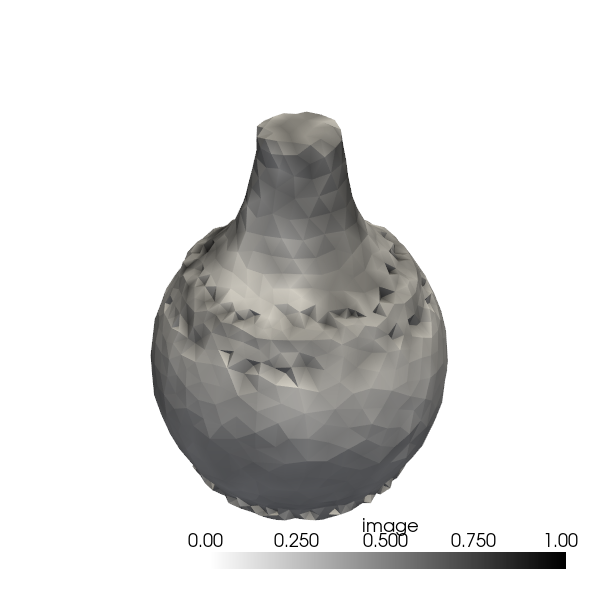

In [51]:
import project.visual.pyvista
mesh = project.core.fileio.load_meshio(ex.paths['interp_mesh'])

pv_mesh = pv.wrap(mesh)
p = pv.Plotter(window_size=(600,600))
p.add_mesh(pv_mesh, scalars='image', cmap='binary', opacity=1.0, clim=(0,1))
#p.add_mesh(pv_mesh.slice(normal=[1,1,1], origin=pv_mesh.center), scalars='image', cmap='binary', clim=(0,1))
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/TEST/1e5abf0465d97d826118a17db9de8c0/images/pad37_regions_material_solid.nii.gz


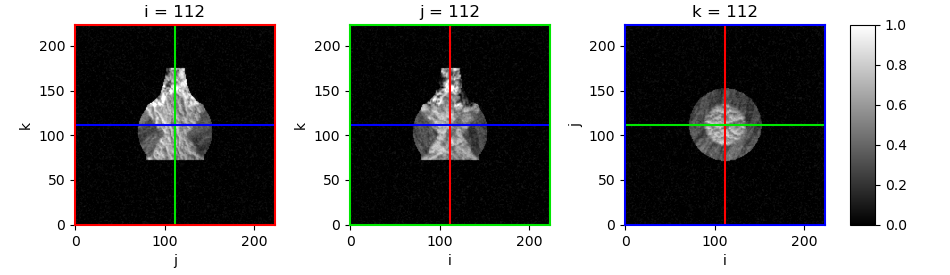

In [52]:
import project.visual.matplotlib
nifti = project.core.fileio.load_nibabel(ex.paths['input_image'])
image = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(image, cmap='gray', clim=(0,1))

In [53]:
mesh = project.core.fileio.load_meshio(ex.paths['interp_mesh'])
mesh

Loading ../../data/ShapeNetSem/TEST/1e5abf0465d97d826118a17db9de8c0/meshes/pad37_regions_material_solid_tetmesh_mat_int.xdmf


<meshio mesh object>
  Number of points: 3246
  Number of cells:
    tetra: 15153
  Point data: mat, rho, E, image
  Cell data: medit:ref, region, material, rho, E, image

In [56]:
optim_cfg = config['optimization'].copy()
optim_cfg['physics_adapter']['rho_known'] = False
optim_cfg['physics_adapter']['scalar_degree'] = 1
optim_cfg['pde_solver']['tv_reg_weight'] = 1e-4
optim_cfg

{'parameters': {'init_value': 3.0, 'param_func': 'pow10'},
 'physics_adapter': {'nu_value': 0.4,
  'rho_bias': 1000,
  'rho_known': False,
  'scalar_degree': 1,
  'vector_degree': 1},
 'pde_solver': {'_class': 'WarpFEMSolver', 'tv_reg_weight': 0.0001},
 'optimizer': {'_class': 'LBFGS',
  'lr': 1.0,
  'max_iter': 100,
  'history_size': 10,
  'line_search_fn': 'strong_wolfe'}}

In [63]:
%autoreload
import project.optimization
output_path = outputs.mesh_path(ex, 'optimized')
metrics = project.optimization.optimize_example(ex, optim_cfg, output_path)
metrics

Loading ../../data/ShapeNetSem/TEST/1e5abf0465d97d826118a17db9de8c0/meshes/pad37_regions_material_solid_tetmesh_mat_int.xdmf
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	3.3229e+00 (nan)	9.3476e-06 (1.0000e+00)	1.9676e+02 (nan)
1	4.4468e-02 (9.8662e-01)	9.3476e-06 (1.0000e+00)	1.9676e+02 (0.0000e+00)
Optimization converged
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	4.4468e-02 (nan)	1.0409e-05 (1.0000e+00)	1.9856e+02 (nan)
1	1.0345e-04 (9.9767e-01)	4.4440e-06 (4.2694e-01)	1.9797e+02 (0.0000e+00)
Optimization converged
dict(len=9)
├── 'volume':   Tensor(shape=torch.Size([15153]), dtype=torch.float32, device=cpu)
|   ├── 0: torch.float32(1.1651e-06)
|   ├── 1: torch.float32(2.6277e-07)
|   ├── 2: torch.float32(1.6698e-07)
|   ├── 3: torch.float32(1.0922e-06)
|   ├── 4: torch.float32(6.6244e-07)
|   ├── 5: torch.float32(1.0861e-06)
|   ├── 6: torch.float32(2.4667e-07)
|   ├── 7: torch.float32(8.1765e-07)
|   ├── 8: torch.float32(1.0690e-0

,epoch,phase,batch,loss,subject,rho_cell.mean,rho_cell.rms,rho_cell.rmse,rho_cell.nrmse,rho_cell.srmse,...,u_cell.nrmse,u_cell.srmse,u_cell.pcorr,u_cell.scorr,res_cell.mean,res_cell.rms,num_materials,dataset,variant,method
0,0,optimize,0,0.000099,wss.1e5abf0465d97d826118a17db9de8c0,438.737209,463.017907,105.02714,0.266147,0.84023,...,0.007447,0.011802,0.999961,0.999349,0.007511,0.015557,3,ShapeNet,TEST,optimize


In [114]:
mesh = project.core.fileio.load_meshio(output_path)
pv_mesh = pv.wrap(mesh)
pv_mesh

Loading outputs/optimize/wss.1e5abf0465d97d826118a17db9de8c0/meshes/optimized.xdmf


UnstructuredGrid (0x148008c68dc0)
  N Cells:    15153
  N Points:   3246
  X Bounds:   -4.564e+02, 4.516e+02
  Y Bounds:   -4.563e+02, 4.574e+02
  Z Bounds:   -5.414e-01, 1.136e+03
  N Arrays:   24

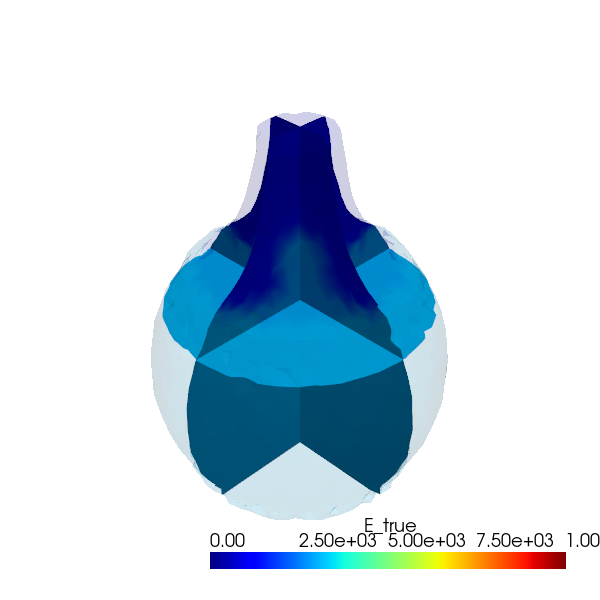

In [115]:
size = 600
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_true', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_true', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

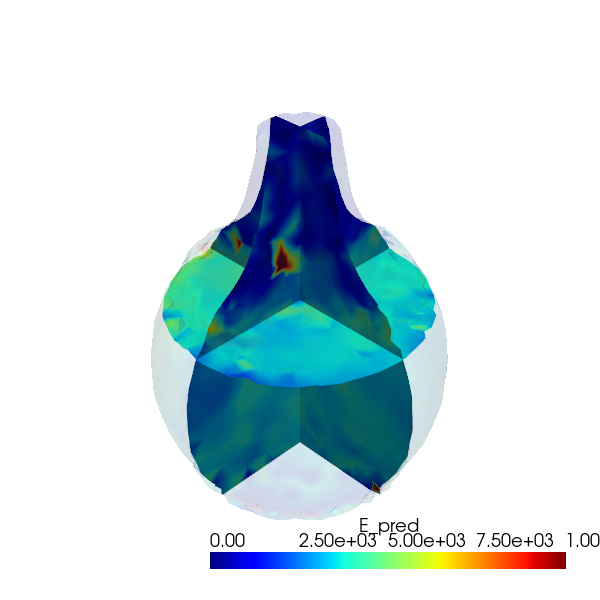

In [118]:
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_pred', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_pred', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

In [108]:
%%time
project.preprocessing.api.rasterize_elasticity_field(
    image_path=ex.paths['input_image'],
    mesh_path=Path('optimize.xdmf'),
    output_path=Path('rasterized.nii.gz'),
    unit_m=ex.metadata['unit'],
    nu_value=0.4,
    scalar_degree=1,
    E_key='E_opt'
)

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 13.8 μs


AttributeError: module 'project' has no attribute 'preprocessing'

In [ ]:
import project.visual.matplotlib

nifti = project.core.fileio.load_nibabel(ex.paths['material_mask'])
mask = nifti.get_fdata().astype(int)
_ = project.visual.matplotlib.show_image_slices(mask, cmap='jet', clim=(0, 10))

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
E_true = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(E_true, cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(Path('rasterized.nii.gz'))
E_pred = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(E_pred, cmap='jet', clim=(0, 1e4))

# Inverse optimization development

In [21]:
mesh_path = ex.paths['volume_mesh']
density_path = ex.paths['density_field']
elastic_path = ex.paths['elastic_field']
unit = ex.metadata['unit']
unit

0.0136197560186615

In [22]:
mesh = project.core.fileio.load_meshio(mesh_path)
density_nifti = project.core.fileio.load_nibabel(density_path)
elastic_nifti = project.core.fileio.load_nibabel(elastic_path)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz


In [8]:
affine_d = density_nifti.affine
affine_e = elastic_nifti.affine
np.allclose(affine_d, affine_e)

True

In [9]:
rho_field = density_nifti.get_fdata().astype(np.float32)
E_field = elastic_nifti.get_fdata().astype(np.float32)
rho_field.shape == E_field.shape

True

In [11]:
import project.core.transforms
pts_voxel = project.core.transforms.world_to_voxel_coords(mesh.points, affine_d)

In [12]:
tensor_kws = dict(dtype=torch.float32, device='cuda')
pts_tensor = torch.as_tensor(pts_voxel, **tensor_kws)
rho_tensor = torch.as_tensor(rho_field, **tensor_kws).unsqueeze(0)
E_tensor = torch.as_tensor(E_field, **tensor_kws).unsqueeze(0)
pts_tensor.shape, rho_tensor.shape, E_tensor.shape

(torch.Size([6846, 3]),
 torch.Size([1, 224, 224, 224]),
 torch.Size([1, 224, 224, 224]))

In [14]:
import project.core.interpolation
rho_nodes = project.core.interpolation.interpolate_image(rho_tensor, pts_tensor)
E_nodes = project.core.interpolation.interpolate_image(E_tensor, pts_tensor)
print(rho_nodes.mean())
print(E_nodes.mean())
rho_nodes.shape, E_nodes.shape

tensor(394.1529, device='cuda:0')
tensor(2411.2158, device='cuda:0')


(torch.Size([6846, 1]), torch.Size([6846, 1]))

In [15]:
nu_value = 0.4
mu_nodes, lam_nodes = project.core.transforms.compute_lame_parameters(E_nodes, nu_value)
bc_nodes = torch.zeros_like(pts_tensor, **tensor_kws)